In [1]:
%load_ext autoreload
%autoreload 2

# Large datasets

The data map is great to work with the data directly, but to do large scale data manipulation or exploration for multiple runs or simulations it falls short.

To work with large datasets, *duqtools* uses [xarray](https://docs.xarray.dev) to store the data in a more managable format. This section shows how you can get the data into xarray. First, we define where to get the data from.

In [2]:
from duqtools.api import ImasHandle

paths = (
    'jet/94875/8100',
    'jet/94875/8101',
    'jet/94875/8102',
    'jet/94875/8103',
)
handles = [ImasHandle.from_string(p) for p in paths]

## Defining variables

Then we must define the relations between the data. This is done via the `Variable` model.

This gives the name of the variable (user defined), the ids to grab it from, the path to the data. Note that the time dimension can be defined by `*`, which links this dimension to the variable named `time`. 

The special character `*` denotes that it is a dimension, which should also be specified in the `dims` list. 

Variables like `zeff` and others use `rho_tor_norm` as the coordinate. But, unfortunately, `rho_tor_norm` differs slightly between time steps. Therefore we first assign an arbitrary placeholder dimension `x`. We will solve this in the next cell.

In [3]:
from duqtools.api import Variable

variables = (
    Variable(name='zeff',
             ids='core_profiles',
             path='profiles_1d/*/zeff',
             dims=['time','x']),
    Variable(name='t_i_average',
             ids='core_profiles',
             path='profiles_1d/*/t_i_average',
             dims=['time','x']),
    Variable(name='rho_tor_norm',
             ids='core_profiles',
             path='profiles_1d/*/grid/rho_tor_norm',
             dims=['time','x']),
    Variable(name='time',
             ids='core_profiles',
             path='time',
             dims=['time']),
)

## Standardize the grid

IMAS data may not be on the same grid (i.e. x-values do not corespond between data sets) or use the same time steps. Therefore, the data must be standardized to the same set of reference coordinates so that the grid and time stamps correspond between different data sets. Because this is such a common operation, *duqtools* has helper functions to deal with these special cases. `standardize_grid` and `rebase_on_grid` helps to rebase on the grid, and `rebase_on_time` to rebase on the time stamps.

We assigned placeholder dimensions (`x`) to the data variables, `zeff`, `t_i_average` and `rho_tor_norm`. To make `rho_tor_norm` internally consistent for each dataset, we can use `standardize_grid()`.

We pass the dimension along which to group the data (`time`), the name of the old dimension (`x`), and the new dimension to use as the new dimension (`rho_tor_norm`). For `new_dim_data`, we can pass the coordinates to use, or an integer to grab the coordinates from the group with this index.

The resulting datasets now have `rho_tor_norm` as a dimension. The data within each group are interpolated to match this grid.

In [4]:
from duqtools.ids import standardize_grid

datasets = []

for handle in handles:
    ids = variables[0].ids
    
    data_map = handle.get(ids)
    ds = data_map.to_xarray(variables=variables)
    
    ds = standardize_grid(
        ds,
        new_dim='rho_tor_norm',
        old_dim='x',
        new_dim_data=0,
        group='time',
    )
    datasets.append(ds)

Now that all datasets have internally consistent `rho_tor_norm`, we can interpolate all datasets to the same reference grid using `rebase_on_grid()`.

In [5]:
from duqtools.ids import rebase_on_grid

reference_grid = datasets[0]['rho_tor_norm'].data

datasets = [
    rebase_on_grid(ds, 
                   coord_dim='rho_tor_norm', 
                   new_coords=reference_grid)
    for ds in datasets
]

## Time rebasing

We do the same for the time coordinate using `rebase_on_time()`.

For example, if your reference data set has timestamps (1.0, 2.0, 3.0, 4.0), and another (1.0, 3.0, 5.0). The data in the second dataset will be interpolated to match the timestamps of the reference. 

If you know your data have the same time stamps, for example if they are from the same set of simulations, you can skip this step.

In [6]:
from duqtools.ids import rebase_on_time

reference_time = datasets[0]['time'].data

datasets = [
    rebase_on_time(ds, 
                   time_dim='time', 
                   new_coords=reference_time)
    for ds in datasets
]

## Data concatenation

Finally, we can concatenate along the run dimension. We set the run coordinates to the name of the data so they can be re-used later.

In [7]:
import xarray as xr

dataset = xr.concat(datasets, 'run')
dataset['run'] = list(paths)

Now we have the data in a nicely structured xarray dataset.

In [8]:
dataset

<xarray.Dataset>
Dimensions:       (run: 4, time: 2, rho_tor_norm: 100)
Coordinates:
  * rho_tor_norm  (rho_tor_norm) float64 0.005025 0.01508 0.02513 ... 0.9899 1.0
  * time          (time) float64 48.35 48.4
  * run           (run) <U14 'jet/94875/8100' ... 'jet/94875/8103'
Data variables:
    zeff          (run, time, rho_tor_norm) float64 1.21 1.21 ... 1.43 1.457
    t_i_average   (run, time, rho_tor_norm) float64 9.492e+03 ... 643.8

## Plotting

Now that we have standardized and rebased the grid and time coordinates, plotting and other operations on the data becomes straightforward. 

`xarray` has some built-in functionality to make plots using [matplotlib](https://matplotlib.org).

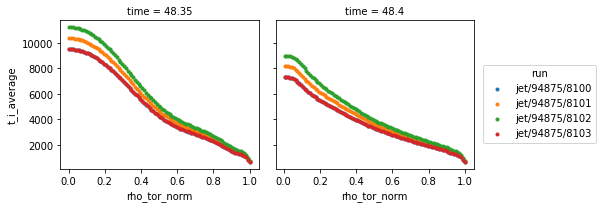

In [9]:
dataset.plot.scatter(
    'rho_tor_norm', 
    't_i_average',       
    hue='run', 
    col='time', 
    marker='.'
)

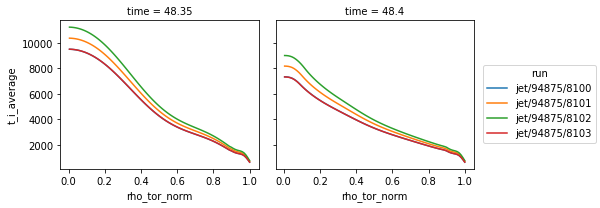

In [10]:
dataset['t_i_average'].plot.line(
    x='rho_tor_norm',
    hue='run', 
    col='time', 
)

*Duqtools* has some built-in plots as well, using [altair](https://altair-viz.github.io/), that are designed with larger data sets and interactivity in mind.

In [11]:
from duqtools.api import alt_line_chart

chart = alt_line_chart(
    dataset, 
    x='rho_tor_norm', 
    y='t_i_average'
)
chart

alt.Chart(...)

alternatively, the data can be plotted using an error band.

In [12]:
from duqtools.api import alt_errorband_chart

chart = alt_errorband_chart(
    dataset, 
    x='rho_tor_norm', 
    y='t_i_average'
)
chart

alt.LayerChart(...)

## Data reduction

To reduce the data along some dimension, we can use `dataset.reduce()`. This method takes a function as the first argument, and will apply it for each slice in the given dimension. `xarray` has some shortcuts for common operators, so `dataset.reduce(np.mean, dim='run')` is equivalent to `dataset.mean(dim='run')`.

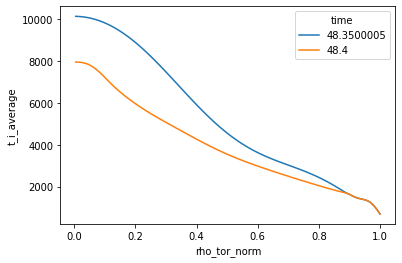

In [13]:
mean = dataset.mean(dim='run')

mean['t_i_average'].plot.line(
    x='rho_tor_norm',
    hue='time', 
)

This can be used to calculate the standard deviation on the data.

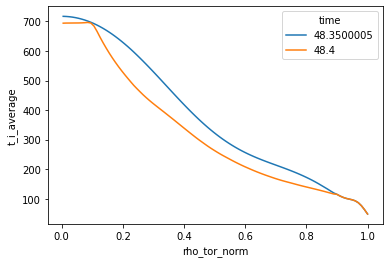

In [14]:
std = dataset.std(dim='run')

std['t_i_average'].plot.line(
    x='rho_tor_norm',
    hue='time', 
)